In [93]:
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

ORIGINAL_FILE_PATH = "itops-706681.json.split-1"
"""original dump file"""
SINGLE_JSON_FILE_PATH = "single.json"
"""sample file holding a single json file"""
ERRORONOUS_JSONS_FILE_PATH = "error.jsonl"
"""file to hold jsons which produced errors while parsing"""

MILLISECONDS_SINCE_EPOCH = int
START_OF_TIME_TIMESTAMP = -(1 << 63)
END_OF_TIME_TIMESTAMP = (1 << 63) - 1


def epoch_to_datetime(milliseconds_since_epoch: MILLISECONDS_SINCE_EPOCH):
    return datetime.fromtimestamp(milliseconds_since_epoch / 1000)

In [130]:
class DateTimeRange:
    """Class to represent a date and time range"""
    def __init__(self, start: MILLISECONDS_SINCE_EPOCH, end: MILLISECONDS_SINCE_EPOCH):
        if start > end:
            raise ValueError("Start date must be before end date")
        self._start_datetime = start
        self._end_datetime = end
    
    def range_value(self):
        return self._end_datetime - self._start_datetime
    
    def __eq__(self, other):
        if isinstance(other, DateTimeRange):
            return self._end_datetime == other._end_datetime and self._start_datetime == other._start_datetime
        return False
    
    def __hash__(self):
        # Using tuple hash
        return hash((self._start_datetime, self._end_datetime))
    
    def __repr__(self) -> str:
        return f"DateTimeRange(start={self._start_datetime},end={self._end_datetime})"

class DateTimeRangeBucket(DateTimeRange):
    """Class to represent a date and time range bucket, to be used for bucketing queries"""
    def intersection_value_with_range(self, datetime_range: DateTimeRange) -> int:
        """Find milliseconds of this bucket common with a given :class:`DateTimeRange`"""
        if datetime_range._end_datetime < self._start_datetime or datetime_range._start_datetime > self._end_datetime:
            return 0
        return min(self._end_datetime, datetime_range._end_datetime) - max(
            self._start_datetime, datetime_range._start_datetime
        )
    
    def __hash__(self):
        return super().__hash__()
    
    def __eq__(self, other):
        if isinstance(other, DateTimeRangeBucket):
            return self._end_datetime == other._end_datetime and self._start_datetime == other._start_datetime
        return False
    
    def __repr__(self) -> str:
        return f"DateTimeRangeBucket(start={self._start_datetime},end={self._end_datetime})"

In [95]:
from dataclasses import dataclass


@dataclass(frozen=True)
class RequiredFieldsOfQuery:
    """Class holder to hold the data time range and partner id of a query"""

    partner_id: int
    data_datetime_range: DateTimeRange


# class RequiredFieldsOfQuery:


#     def __init__(
#         self,
#         ctxPId: int,
#         sinceTime: MILLISECONDS_SINCE_EPOCH,
#         untilTime: MILLISECONDS_SINCE_EPOCH
#     ) -> None:
#         self._partner_id = ctxPId
#         self._data_start_time = epoch_to_datetime(sinceTime)
#         self._data_end_time = epoch_to_datetime(untilTime)

#     @property
#     def partner_id(self) -> int:
#         return self._partner_id

#     @property
#     def start_time(self) -> datetime:
#         return self._data_start_time

#     @property
#     def end_time(self) -> datetime:
#         return self._data_end_time


def read_single_query_file(filePath: str):
    """read a single json query object from a file"""
    with open(filePath) as json_file:
        # data is the dict form of one query
        data = json.load(json_file)
        print(data)

def generator(filePath: str):
    """generator for memory efficient handling of large dump files, yields json object"""
    bad_json_file_handler = open(ERRORONOUS_JSONS_FILE_PATH, "w")
    with open(filePath, "r") as file:
        for line in file:
            try:
                json_object = json.loads(line.strip())
                yield json_object
            except Exception as e:
                # Have to handle exceptions inside generator, otherwise it will not yield anymore
                bad_json_file_handler.write(line + "\n")
                print(e)
                continue
        bad_json_file_handler.close()


def read_multi_query_file_at_once(filePath: str):
    """Read all queries from a file as json objects and load them into memory at once"""
    return tuple(generator(filePath))

In [96]:
def time_range_parser_generator(filePath: str):
    """A generator that gives start time, end time of data involved in query and partner id as a :class:`RequiredFieldsOfQuery` object"""
    bad_json_file_handler = open(ERRORONOUS_JSONS_FILE_PATH, "w")
    with open(filePath, "r") as file:
        for line in file:
            try:
                json_object = json.loads(line.strip())
                time_range_elements = (
                    json_object["_source"]["attributes"]["context"]["timeRange"]
                    .lstrip("Range{")
                    .rstrip("}")
                    .split(",")[:2]
                )
                yield RequiredFieldsOfQuery(
                    json_object["_source"]["ctxPId"],
                    # Type casting safety checked for 64 bit numbers
                    DateTimeRange(
                        int(time_range_elements[0].lstrip("from=").strip()),
                        int(time_range_elements[1].lstrip(" upto=").strip()),
                    ),
                )
            except Exception as e:
                # Have to handle exceptions inside generator, otherwise it will not yield anymore
                bad_json_file_handler.write(line + "\n")
                print(e)
                continue
        bad_json_file_handler.close()

In [98]:
"""Just for basic testing purposes, should be ignored safely"""

with open("two_queries.jsonl") as f:
    for line in f:
        obj = json.loads(line)
        print(
            obj["_source"]["attributes"]["context"]["timeRange"]
            .lstrip("Range{")
            .rstrip("}")
        )

from=1718164800000, upto=1718344822982, includeLower=true, includeUpper=true
from=1718164800000, upto=1718344822954, includeLower=true, includeUpper=true


In [51]:
"""
Did this just to check if all queries contain the time range inside specific nested keys and fields

Output: All queries contained the required field
"""

# Seperating lines with and without a ["_source"]["attributes"]["context"]["timeRange"] field
file_reader_generator = generator(ORIGINAL_FILE_PATH)
without_context_file_handler = open("without_context_timeRange.jsonl", "w")
lines_without_context = 0
lines_with_context = 0
for json_object in file_reader_generator:
    try:
        time_range_elements = (
            json_object["_source"]["attributes"]["context"]["timeRange"]
            .lstrip("Range{")
            .rstrip("}")
            .split(",")[:2]
        )
        print(
            int(time_range_elements[0].lstrip("from=").strip()),
            int(time_range_elements[1].lstrip(" upto=").strip()),
        )
        lines_with_context += 1
    except KeyError:
        without_context_file_handler.write(json.dumps(json_object))
        lines_without_context += 1
    except Exception as e:
        print("Unexpected error:", e)
without_context_file_handler.close()
# NOTE: All lines contained the timeRange key

1718164800000 1718344822982
1718164800000 1718344822954
1717619580000 1718344824086
1718344480921 1718344824122
1713139200000 1718305200000
1718339400000 1718344800000
1718343620000 1718344824486
1718342417000 1718344824485
1718344222147 1718344824739
1718344502460 1718344824759
1696132800000 1704085199999
1701421200000 1704095999999
1718152200000 1718344825378
1718344506109 1718344825441
1718168400000 1718344825418
1718335211000 1718344825497
1718335210000 1718344825496
1718343620000 1718344825492
1718344507498 1718344825449
1710572400000 1715756399999
1718331608000 1718344825494
1718344461758 1718344825528
1718339400000 1718344800000
1718339400000 1718344800000
1718339400000 1718344800000
1718082000000 1718344825685
1712554587223 1718343387223
1715752826016 1718344826016
1718339400000 1718344800000
1704088800000 1861941599999
1717743600000 1718348399999
1718168400000 1718344829396
1718339400000 1718344800000
1715752829949 1718344829949
1718168400000 1718344830053
1703005414000 170644

In [194]:
from datetime import timedelta
from typing import Any, List, Tuple, Dict, Generator
from copy import deepcopy

TIME_BUCKETS_TYPE = Tuple[DateTimeRangeBucket, ...]
TIME_BUCKETS = tuple[DateTimeRangeBucket, ...]
SINGLE_PARTNER_BUCKET_TYPE = Dict[DateTimeRangeBucket, float]
"""Type alias for dictionary specifying single partner's queries grouped in different time ranges"""
SINGLE_PARTNER_BUCKET_TUPLE_TYPE = Tuple[float, ...]
"""Length of tuple = number of time buckets, length can't be forced programatically"""
SINGLE_PARTNER_BUCKET = dict[DateTimeRangeBucket, float]
SINGLE_PARTNER_BUCKET_TUPLE = tuple[float]
PARTNER_ID_TYPE = int
ALL_PARTNERS_BUCKET_TYPE = Dict[PARTNER_ID_TYPE, SINGLE_PARTNER_BUCKET_TYPE]
ALL_PARTNERS_BUCKET_TUPLE_TYPE = Dict[PARTNER_ID_TYPE, SINGLE_PARTNER_BUCKET_TUPLE_TYPE]
ALL_PARTNERS_BUCKET = dict[PARTNER_ID_TYPE, SINGLE_PARTNER_BUCKET_TYPE]
ALL_PARTNERS_BUCKET_TUPLE = dict[PARTNER_ID_TYPE, SINGLE_PARTNER_BUCKET_TUPLE_TYPE]


def validate_time_bucket_boundaries(
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> None:
    """
    validator function for a tuple of timestamps demarkating time buckets' boundaries
    Currently just verifies that the given list is non empty and has no duplicate entries
    """
    if len(bucket_timerange_start_boundaries) < 1:
        raise ValueError("No time buckets specified")
    bucket_timerange_start_boundaries = tuple(sorted(bucket_timerange_start_boundaries))
    for idx in range(len(bucket_timerange_start_boundaries) - 1):
        if (
            bucket_timerange_start_boundaries[idx]
            == bucket_timerange_start_boundaries[idx + 1]
        ):
            raise ValueError("Duplicate buckets specified")

def time_buckets_from_boundaries(
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> Tuple[DateTimeRangeBucket, ...]:
    """
    Function to create time buckets covering from :const:`START_OF_TIME_TIMESTAMP` to :const:`END_OF_TIME_TIMESTAMP` with buckets demarkated at the date and time values corresponding to :arg:`bucket_timerange_start_boundaries` adjusted with respect to the current timestamp, :const:`START_OF_TIME_TIMESTAMP` and :const:`END_OF_TIME_TIMESTAMP`
    NOTE: this function does not validate the :arg:`bucket_timerange_start_boundaries` given to it
    """
    time_buckets = list[DateTimeRangeBucket]()
    current_timestamp = int(datetime.now().timestamp() * 1000)
    time_buckets.append(DateTimeRangeBucket(current_timestamp, END_OF_TIME_TIMESTAMP))
    last_bucket_start_timestamp = current_timestamp
    for bucket_start_boundary in bucket_timerange_start_boundaries:
        current_bucket_start_timestamp = current_timestamp - int(
            bucket_start_boundary.total_seconds() * 1000
        )
        time_buckets.append(
            DateTimeRangeBucket(
                current_bucket_start_timestamp, last_bucket_start_timestamp - 1
            )
        )
        last_bucket_start_timestamp = current_bucket_start_timestamp
    time_buckets.append(
        DateTimeRangeBucket(START_OF_TIME_TIMESTAMP, last_bucket_start_timestamp - 1)
    )
    return tuple(time_buckets)


def validate_and_make_time_buckets_from_boundaries(
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> Tuple[DateTimeRangeBucket, ...]:
    """Validate the :arg:`bucket_timerange_start_boundaries` and create tiem buckets corresponding to it"""
    validate_time_bucket_boundaries(bucket_timerange_start_boundaries)
    return time_buckets_from_boundaries(bucket_timerange_start_boundaries)


def empty_buckets_dictionary_from_time_buckets(
    time_buckets: Tuple[DateTimeRangeBucket, ...],
) -> SINGLE_PARTNER_BUCKET_TYPE:
    """creates a template dictionary for a single partner with keys as given time buckets"""
    return {time_bucket: 0 for time_bucket in time_buckets}


def empty_buckets_dictionary_from_time_boundaries(
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> SINGLE_PARTNER_BUCKET_TYPE:
    """
    Create a :type:`SINGLE_PARTNER_BUCKET_TYPE` with time buckets bounded by :arg:`bucket_timerange_start_boundaries` and the current time, :constant:`START_OF_TIME_TIMESTAMP` and :constant:`END_OF_TIME_TIMESTAMP`
    """
    empty_buckets_dict = SINGLE_PARTNER_BUCKET()
    current_timestamp = int(datetime.now().timestamp() * 1000)
    empty_buckets_dict[
        DateTimeRangeBucket(current_timestamp, END_OF_TIME_TIMESTAMP)
    ] = 0
    last_bucket_start_timestamp = current_timestamp
    for bucket_start_boundary in bucket_timerange_start_boundaries:
        current_bucket_start_timestamp = current_timestamp - int(
            bucket_start_boundary.total_seconds() * 1000
        )
        empty_buckets_dict[
            DateTimeRangeBucket(
                current_bucket_start_timestamp, last_bucket_start_timestamp - 1
            )
        ] = 0
        last_bucket_start_timestamp = current_bucket_start_timestamp
    empty_buckets_dict[
        DateTimeRangeBucket(START_OF_TIME_TIMESTAMP, last_bucket_start_timestamp - 1)
    ] = 0
    return empty_buckets_dict


def validate_and_make_empty_buckets_dictionary_from_time_boundaries(
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> SINGLE_PARTNER_BUCKET_TYPE:
    """same as :function:`empty_buckets_dictionary_from_time_boundaries` with added validation of :arg:`bucket_timerange_start_boundaries` before creating the template dictionary"""
    validate_time_bucket_boundaries(bucket_timerange_start_boundaries)
    return empty_buckets_dictionary_from_time_boundaries(
        bucket_timerange_start_boundaries
    )


def mutual_exclusive_bucketing(
    object_generator: Generator[RequiredFieldsOfQuery, Any, None],
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> ALL_PARTNERS_BUCKET_TYPE:
    """
    Function that groups queries into time range buckets by finding the most recent boundary lte start time of the query
    Queries having time range -2^63 to (2^63)-1, are put into all buckets

    Args:
        bucket_timerange_start_boundaries (:variable:`List`[:class:`timedelta`])
    Returns:
     an :type:`ALL_PARTNERS_BUCKET_TYPE` dictionary
    """
    validate_time_bucket_boundaries(bucket_timerange_start_boundaries)
    empty_buckets_dict = empty_buckets_dictionary_from_time_boundaries(
        bucket_timerange_start_boundaries
    )
    time_buckets = list(empty_buckets_dict.keys())
    time_buckets.sort(
        key=lambda dt_range: (dt_range._start_datetime, dt_range._end_datetime)
    )
    all_partners_buckets = ALL_PARTNERS_BUCKET()
    for single_query_object in object_generator:
        curr_partner_id = single_query_object.partner_id
        if all_partners_buckets.get(curr_partner_id, None) == None:
            all_partners_buckets[curr_partner_id] = deepcopy(empty_buckets_dict)
        curr_data_time_range = single_query_object.data_datetime_range
        curr_data_range = curr_data_time_range.range_value()
        curr_partner_bucket = all_partners_buckets[curr_partner_id]
        for time_bucket in time_buckets:
            try:
                curr_partner_bucket[time_bucket] += (
                    time_bucket.intersection_value_with_range(curr_data_time_range)
                    / curr_data_range
                )
            except Exception as e:
                print("unknow error: ", e)
    return all_partners_buckets


def mutual_exclusive_bucketing_tuples(
    object_generator: Generator[RequiredFieldsOfQuery, Any, None],
    bucket_timerange_start_boundaries: Tuple[timedelta, ...],
) -> ALL_PARTNERS_BUCKET_TUPLE_TYPE:
    """
    Bucket all queries given by the :arg:`object_generator` as per partners and by creating time buckets corresponding to :arg:`bucket_timerange_start_boundaries`, :constant:`START_OF_TIME_TIMESTAMP` and :constant:`END_OF_TIME_TIMESTAMP`
    Validates :arg:`bucket_timerange_start_boundaries` and does not handle exceptions raised by the validating method
    """
    validate_time_bucket_boundaries(bucket_timerange_start_boundaries)
    time_buckets = time_buckets_from_boundaries(bucket_timerange_start_boundaries)
    num_of_time_buckets = len(time_buckets)
    all_partners_buckets = dict[PARTNER_ID_TYPE, List[float]]()
    for single_query_object in object_generator:
        curr_partner_id = single_query_object.partner_id
        if all_partners_buckets.get(curr_partner_id, None) == None:
            all_partners_buckets[curr_partner_id] = [
                0 for _ in range(num_of_time_buckets)
            ]
        curr_data_time_range = single_query_object.data_datetime_range
        curr_data_range = curr_data_time_range.range_value()
        curr_partner_bucket = all_partners_buckets[curr_partner_id]
        for idx, time_bucket in enumerate(time_buckets):
            curr_partner_bucket[idx] += (
                time_bucket.intersection_value_with_range(curr_data_time_range)
                / curr_data_range
            )
    all_partner_buckets_tuple = ALL_PARTNERS_BUCKET_TUPLE()
    # Type casting all partners' buckets one by one
    for partner in list(all_partners_buckets.keys()):
        all_partner_buckets_tuple[partner] = SINGLE_PARTNER_BUCKET_TUPLE(all_partners_buckets[partner])
        del all_partners_buckets[partner]
    return all_partner_buckets_tuple


def mutual_exclusive_bucketing_tuples_from_time_buckets(
    object_generator: Generator[RequiredFieldsOfQuery, Any, None],
    time_buckets: Tuple[DateTimeRangeBucket, ...],
) -> ALL_PARTNERS_BUCKET_TUPLE_TYPE:
    """
    Bucket all queries given by the :arg:`object_generator` as per partners and time buckets given by :arg:`time_buckets`
    """
    num_of_time_buckets = len(time_buckets)
    all_partners_buckets = dict[PARTNER_ID_TYPE, List[float]]()
    for single_query_object in object_generator:
        curr_partner_id = single_query_object.partner_id
        if all_partners_buckets.get(curr_partner_id, None) == None:
            all_partners_buckets[curr_partner_id] = [
                0 for _ in range(num_of_time_buckets)
            ]
        curr_data_time_range = single_query_object.data_datetime_range
        curr_data_range = curr_data_time_range.range_value()
        curr_partner_bucket = all_partners_buckets[curr_partner_id]
        for idx, time_bucket in enumerate(time_buckets):
            curr_partner_bucket[idx] += (
                time_bucket.intersection_value_with_range(curr_data_time_range)
                / curr_data_range
            )
    all_partner_buckets_tuple = ALL_PARTNERS_BUCKET_TUPLE()
    # Type casting all partners' buckets one by one
    for partner in list(all_partners_buckets.keys()):
        all_partner_buckets_tuple[partner] = SINGLE_PARTNER_BUCKET_TUPLE(all_partners_buckets[partner])
        del all_partners_buckets[partner]
    return all_partner_buckets_tuple

In [199]:
def time_bucket_repr(time_bucket: DateTimeRangeBucket) -> str:
    """To get string representation for purpose of legend in plots"""
    return f"{"START_OF_TIME" if time_bucket._start_datetime == START_OF_TIME_TIMESTAMP else epoch_to_datetime(time_bucket._start_datetime).date()} to {"END_OF_TIME" if time_bucket._end_datetime == END_OF_TIME_TIMESTAMP else epoch_to_datetime(time_bucket._end_datetime).date()}"

def write_bucket_dicts_to_file(buckets: ALL_PARTNERS_BUCKET_TYPE, file_path: str) -> None:
    """Function to write an :type:`ALL_PARTNERS_BUCKET_TYPE` object to a file in tabular manner"""
    try:
        assert len(buckets) > 0
    except AssertionError:
        raise ValueError("Empty buckets given")
    try:
        time_buckets_used = (next(iter(buckets.values()))).keys()
    except:
        raise ValueError("Error while reading time buckets used")
    with open(file_path, "w") as buckets_file:
        buckets_file.write(f"Number of partners:{len(buckets)}\nTime Buckets used:{list(time_buckets_used)}\nTime buckets in human readable form:{str([time_bucket_repr(time_bucket) for time_bucket in time_buckets_used])}\n")
        for partner_id, partner_bucket in buckets.items():
            buckets_file.write(f"{str(partner_id)}:{list(partner_bucket.values())}\n")

def read_bucket_dicts_from_file(file_path: str) -> (TIME_BUCKETS_TYPE, ALL_PARTNERS_BUCKET_TYPE):
    """Function to parse :type:`ALL_PARTNERS_BUCKET_TYPE` object from a file and the corresponding :type:`TIME_BUCKETS_TYPE` buckets used"""
    with open(file_path) as file:
        number_of_partners_line= file.readline()
        print(number_of_partners_line)
        try:
            number_of_partners = eval(number_of_partners_line.split(":")[-1].strip("\n"))
            assert type(number_of_partners) == int
        except AssertionError as e:
            raise Exception("ERROR: malformed file at line 1, exiting parsing")
        time_buckets_line = file.readline()
        try:
            time_buckets_used: TIME_BUCKETS_TYPE = TIME_BUCKETS(eval(time_buckets_line.split(":")[-1]))
        except:
            raise Exception("ERROR: malformed file at line 2, exiting parsing")
        human_readable_time_buckets = file.readline()
        print(human_readable_time_buckets)
        all_partners_buckets = ALL_PARTNERS_BUCKET()
        number_of_time_buckets = len(time_buckets_used)
        for _ in range(number_of_partners):
            current_partner_line = file.readline()
            id_part, query_part = current_partner_line.split(":")
            try:
                current_partner_id = eval(id_part)
                assert type(current_partner_id) == PARTNER_ID_TYPE
            except:
                raise Exception(f"ERROR: malformed partner id in line: {current_partner_line}. Exiting parsing")
            try:
                current_partner_entries = eval(query_part)
                assert type(current_partner_entries) == list
                current_partner_bucket = {}
                for idx in range(number_of_time_buckets):
                    current_partner_bucket[time_buckets_used[idx]] = current_partner_entries[idx]
            except:
                raise Exception(f"ERROR: malformed partner buckets in line: {current_partner_line}. Exiting parsing")
            all_partners_buckets[current_partner_id] = current_partner_bucket
    return (time_buckets_used, all_partners_buckets)


In [151]:
bucketing_scheme_1_timedeltas = tuple(
    [timedelta(num_days) for num_days in [7, 30, 60, 180, 365]]
)
bucketing_scheme_1 = mutual_exclusive_bucketing(
    time_range_parser_generator(ORIGINAL_FILE_PATH), bucketing_scheme_1_timedeltas
)

In [152]:
from sys import getsizeof

print(getsizeof(bucketing_scheme_1))

73808


In [200]:
write_bucket_dicts_to_file(bucketing_scheme_1, "scheme_1.report_3.txt")

In [177]:
import matplotlib.pyplot as plt

def plot_and_save_buckets(directory_path: str, buckets: ALL_PARTNERS_BUCKET_TYPE) -> None:
    """
    Function to plot pie charts of the buckets and save them to :arg:`directory_path`.
    Each plot is uniquely identified by the partner id it represents
    """
    for partner_id, partner_bucket in buckets.items():
        plt.figure(partner_id)
        non_zero_values, non_zero_keys = [], []
        for key, value in partner_bucket.items():
            if round(value, 3) != 0:
                non_zero_values.append(value)
                non_zero_keys.append(f"{time_bucket_repr(key)}:{str(round(value, 3))}")
        plt.pie(non_zero_values)
        plt.legend(non_zero_keys, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(str(partner_id))
        plt.tight_layout()
        plt.savefig(f"{directory_path}/{str(partner_id)}.png", bbox_inches='tight')
        plt.close(partner_id)

def plot_and_save_tuple_buckets(directory_path: str, buckets: ALL_PARTNERS_BUCKET_TUPLE_TYPE, time_buckets: TIME_BUCKETS_TYPE):
    """For plotting and saving pie charts of buckets in the `Dict[PARTNER_ID_TYPE, List[Float]]` format, given the :arg:`time_buckets` used for bucketing each partner's queries"""
    for partner_id, partner_bucket in buckets.items():
        plt.figure(partner_id)
        try:
            non_zero_values, non_zero_time_buckets = [], []
            for idx, time_bucket in enumerate(time_buckets):
                if round(partner_bucket[idx], 3) > 0:
                    non_zero_values.append(round(partner_bucket[idx], 3))
                    non_zero_time_buckets.append(f"{time_bucket_repr(time_bucket)}:{str(round(partner_bucket[idx], 3))}")
            plt.pie(non_zero_values)
            plt.legend(non_zero_time_buckets, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(str(partner_id))
            plt.tight_layout()
            plt.savefig(f"{directory_path}/{str(partner_id)}.png", bbox_inches='tight')
            plt.close(partner_id)
        except Exception as e:
            print(f"Exception {e} while trying to plot {partner_bucket}")
            plt.close(partner_id)

def plot_single_list_bucket(partner_bucket: SINGLE_PARTNER_BUCKET_TUPLE_TYPE, time_buckets: TIME_BUCKETS_TYPE) -> None:
    """Plotting and showing pie chart of a partner's query's bucket, combined in a :type:`List[float]` format"""
    plt.figure()
    non_zero_values, non_zero_time_buckets = [], []
    for idx, time_bucket in enumerate(time_buckets):
        if round(partner_bucket[idx], 3) > 0:
            non_zero_values.append(round(partner_bucket[idx], 3))
            non_zero_time_buckets.append(f"{time_bucket_repr(time_bucket)}:{str(round(partner_bucket[idx], 3))}")
    plt.pie(non_zero_values)
    plt.legend(non_zero_time_buckets, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_single_bucket(bucket: SINGLE_PARTNER_BUCKET_TYPE) -> None:
    """Plotting and showing pie chart corresponding to a single partner stored in :type:`SINGLE_PARTNER_BUCKET_TYPE` format"""
    plt.figure()
    non_zero_values, non_zero_keys = [], []
    for key, value in bucket.items():
        if round(value, 3) != 0:
            non_zero_values.append(value)
            non_zero_keys.append(f"{time_bucket_repr(key)}:{str(round(value, 3))}")
    plt.pie(non_zero_values)
    plt.legend(non_zero_keys, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [173]:
plot_and_save_buckets("scheme_1-plots", bucketing_scheme_1)

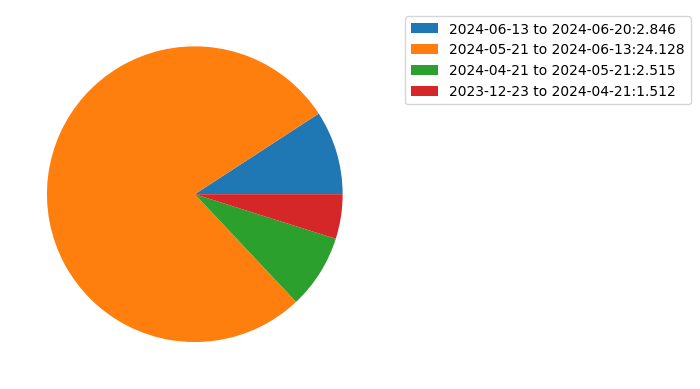

In [157]:
"""Just for seeing a plot"""
plot_single_bucket(bucketing_scheme_1[104])

In [158]:
bucketing_scheme_2_time_buckets = [
    DateTimeRangeBucket(
        MILLISECONDS_SINCE_EPOCH(datetime(2024, 1, 1).timestamp()*1000),
        MILLISECONDS_SINCE_EPOCH(datetime.now().timestamp()*1000),
    ),
    DateTimeRangeBucket(
        MILLISECONDS_SINCE_EPOCH(datetime(2023, 1, 1).timestamp()*1000),
        MILLISECONDS_SINCE_EPOCH(datetime(2024, 1, 1).timestamp()*1000) - 1,
    ),
    DateTimeRangeBucket(
        MILLISECONDS_SINCE_EPOCH(datetime(2022, 1, 1).timestamp()*1000),
        MILLISECONDS_SINCE_EPOCH(datetime(2023, 1, 1).timestamp()*1000) - 1,
    ),
    DateTimeRangeBucket(
        MILLISECONDS_SINCE_EPOCH(datetime(2021, 1, 1).timestamp()*1000),
        MILLISECONDS_SINCE_EPOCH(datetime(2022, 1, 1).timestamp()*1000) - 1,
    ),
]
"""Bucketing queries year wise, starting from the year 2021"""
bucketing_scheme_2_time_buckets.sort(key=lambda dt: (dt._start_datetime, dt._end_datetime))
bucketing_scheme_2_time_buckets = tuple(bucketing_scheme_2_time_buckets)

In [163]:
bucketing_scheme_2 = mutual_exclusive_bucketing_tuples_from_time_buckets(
    time_range_parser_generator(ORIGINAL_FILE_PATH),
    bucketing_scheme_2_time_buckets,
)

In [169]:
"""For comparing with the newer format of storing the buckets for each partner as a List"""
bucketing_scheme_2_as_dictionary = mutual_exclusive_bucketing(time_range_parser_generator(ORIGINAL_FILE_PATH), tuple(sorted(tuple(datetime.now() - epoch_to_datetime(datetime_range._start_datetime) for datetime_range in list(bucketing_scheme_2_time_buckets)))))

In [170]:
"""To compare sizes of buckets stored in different formats"""
print(getsizeof(bucketing_scheme_2_as_dictionary), getsizeof(bucketing_scheme_2))

73808 73808


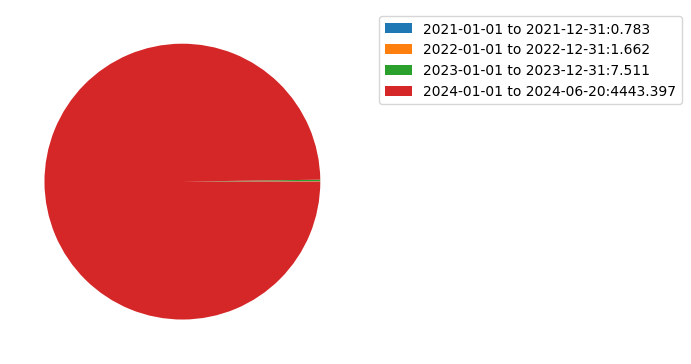

In [178]:
"""Again, just for seeing a single plot"""
plot_single_list_bucket(list(bucketing_scheme_2.values())[0], bucketing_scheme_2_time_buckets)

In [179]:
plot_and_save_tuple_buckets("scheme_2-plots", bucketing_scheme_2, bucketing_scheme_2_time_buckets)

In [91]:
"""
Finding number of partners having only one year with query portion gte 1e-3
"""
num_single_year_query_partners = 0
for partner_bucket_values in bucketing_scheme_2.values():
    non_zero_years = 0
    for year_query_portion in partner_bucket_values:
        if (round(year_query_portion, 3) > 0):
            non_zero_years += 1
            if (non_zero_years > 1):
                break
    if (non_zero_years <= 1):
        num_single_year_query_partners += 1

print(num_single_year_query_partners)

1706


In [92]:
len(bucketing_scheme_2.keys())
"""Total number of partners"""

1893

In [187]:
def write_bucket_tuples_to_file(
    file_path: str,
    buckets: ALL_PARTNERS_BUCKET_TUPLE_TYPE,
    time_buckets_used: Tuple[DateTimeRangeBucket, ...],
) -> None:
    """
    Function to write all partners' buckets of form `dict(partner_id, partner_bucket)` where each `partner_bucket` is of the
    form `tuple[float]`
    """
    try:
        assert len(buckets) > 0
    except:
        raise ValueError("Empty buckets given")
    try:
        assert len(time_buckets_used) > 0
    except:
        raise ValueError("Empty time buckets given")
    with open(file_path, "w") as bucket_file:
        bucket_file.write(
            f"Number of partners:{len(buckets)}\nTime buckets used:{time_buckets_used}\nTime buckets in human readable form: {str([time_bucket_repr(time_bucket) for time_bucket in time_buckets_used])}\n"
        )
        for partner in buckets:
            bucket_file.write(str(partner) + "\n" + str(buckets[partner]) + "\n")

def read_bucket_tuples_from_file(file_path: str) -> tuple[Tuple[DateTimeRangeBucket, ...], ALL_PARTNERS_BUCKET_TUPLE_TYPE]:
    """
    Function to parse file written to through `write_bucket_list_to_file`
    """
    with open(file_path) as file:
        number_of_partners_line= file.readline()
        print(number_of_partners_line)
        try:
            number_of_partners = eval(number_of_partners_line.split(":")[-1].strip("\n"))
            assert type(number_of_partners) == int
        except AssertionError as e:
            raise Exception("ERROR: malformed file at line 1, exiting parsing")
        time_buckets_line = file.readline()
        try:
            time_buckets_used: TIME_BUCKETS_TYPE = TIME_BUCKETS(eval(time_buckets_line.split(":")[-1]))
        except:
            raise Exception("ERROR: malformed file at line 2, exiting parsing")
        human_readable_time_buckets = file.readline()
        print(human_readable_time_buckets)
        all_partners_buckets = ALL_PARTNERS_BUCKET_TUPLE()
        for _ in range(number_of_partners):
            current_partner_id_line = file.readline()
            try:
                current_partner_id = eval(current_partner_id_line)
                assert type(current_partner_id) == PARTNER_ID_TYPE
            except:
                raise Exception(f"ERROR: malformed partner id: {current_partner_id_line}. Exiting parsing")
            current_partner_entry_line = file.readline()
            try:
                current_partner_buckets = SINGLE_PARTNER_BUCKET_TUPLE(eval(current_partner_entry_line))
            except:
                raise Exception(f"ERROR: malformed partner buckets: {current_partner_entry_line}. Exiting parsing")
            all_partners_buckets[current_partner_id] = current_partner_buckets
    return (time_buckets_used, all_partners_buckets)


In [185]:
write_bucket_tuples_to_file("scheme_2-report", bucketing_scheme_2, bucketing_scheme_2_time_buckets)

In [186]:
# For sanity check of the read and write functions
scheme_2_time_buckets, bucketing_scheme_2_from_report_file = read_bucket_tuples_from_file("scheme_2-report")

Number of partners:1893

Time buckets in human readable form: ['2021-01-01 to 2021-12-31', '2022-01-01 to 2022-12-31', '2023-01-01 to 2023-12-31', '2024-01-01 to 2024-06-20']



In [202]:
tb1, bucketing_1 = read_bucket_dicts_from_file("scheme_1.report_3.txt")

Number of partners:1893

Time buckets in human readable form:['2024-06-20 to END_OF_TIME', '2024-06-13 to 2024-06-20', '2024-05-21 to 2024-06-13', '2024-04-21 to 2024-05-21', '2023-12-23 to 2024-04-21', '2023-06-21 to 2023-12-23', 'START_OF_TIME to 2023-06-21']



In [ ]:
bucketing_scheme_1